# Hyperparameter optimization

Our dataset is <= 1GB, but there are many hyperparameters to choose from (learning rate, number of layers, layer 
width, etc.).
The Hyperband search from (Li et al., 2016) and implemented in dask-ml (Sievert et al., 2018)
as [HyperbandCV](https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV)
is designed to handle this exact case: compute but not memory bound hyperparameter optimization


“Hyperband: A novel bandit-based approach to hyperparameter optimization”, 2016 by L. Li, K. Jamieson, G. DeSalvo, A. Rostamizadeh, and A. Talwalkar. https://arxiv.org/abs/1603.06560

“Better and faster hyperparameter optimization with Dask”, 2018 by S. Sievert, T. Augspurger, M. Rocklin. https://doi.org/10.25080/Majora-7ddc1dd1-011

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from scipy.stats import uniform, loguniform
from scikeras.wrappers import KerasRegressor
import dask.array as darray
from dask.distributed import Client, get_client
from dask_ml.model_selection import HyperbandSearchCV

from mlcdc import KerasFeeder, SurfaceFeeder

## Preliminary setup

In [8]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

ds['ocn_ubtav'] = ds['ocn_ubtav'].isel(olev=0)
ds['ocn_vbtav'] = ds['ocn_vbtav'].isel(olev=0)
ds['ocn_baro_srf'] = np.sqrt(ds.ocn_ubtav**2 + ds.ocn_vbtav**2)
ds['ocn_baro_srf'].attrs['long_name'] = 'derived barotropic ocean current speed'

ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)

In [9]:
features_and_labels = [
    'atm_q2m','atm_qrain','atm_t2m','atm_tprcp','atm_speed_srf',
    'ocn_MEKE', 'ocn_MLD', 'ocn_sfc', 'ocn_sst', 'ocn_speed_srf', 'ocn_baro_srf',
    'corr_atm_ocn',
]

In [10]:
for key in features_and_labels:
    if 'long_name' in ds[key].attrs:
        print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed
ocn_baro_srf            : derived barotropic ocean current speed


In [11]:
features = features_and_labels.copy()
features.remove('corr_atm_ocn')

In [12]:
kf = SurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [13]:
kf(ds)

## Setup data in numpy format...

In [14]:
X = np.concatenate([val[...,None] for val in kf.x_training.values()], axis=1)
y = kf.labels['training'].values

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [15]:
def build_model(n_layers=1,
                units_per_layer=16,
                hidden_activation=None,
                regularizer=keras.regularizers.L2,
                regularization=1e-7,
               ):
    
    # hard code this part for now
    ftr = ['atm_q2m', 'atm_qrain', 'atm_t2m','atm_tprcp', 'atm_speed_srf',
           'ocn_MEKE', 'ocn_MLD', 'ocn_sfc', 'ocn_sst', 'ocn_speed_srf', 'ocn_baro_srf']
    
    inputs = keras.Input(shape=(len(ftr,)), name="all_inputs")
    #inputs = [keras.Input(shape=(1,), name=name) for name in ftr]
    
    #hidden = keras.layers.concatenate(inputs)
    for i in range(n_layers):
        this_one = inputs if i == 0 else hidden
        hidden = keras.layers.Dense(
            units=units_per_layer,
            activation=hidden_activation,
            kernel_regularizer=regularizer(regularization),
            bias_regularizer=regularizer(regularization),
        )(this_one)
        
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    model = keras.Model(
        inputs=inputs,
        outputs=[output]
    )
    
    return model

## Try model already "optimized"

In [16]:
model = KerasRegressor(build_model,
                       # args
                       n_layers=18,
                       units_per_layer=16,
                       hidden_activation="tanh",
                       regularizer=keras.regularizers.L1,
                       regularization=4.092099144907797e-6,
                       # args via scikeras
                       loss=keras.losses.MeanAbsoluteError(),
                       optimizer__learning_rate=0.006760844049883218,
                       batch_size=128,
                       # actual scikeras args
                       optimizer=keras.optimizers.Adam,
                       metrics=["mean_squared_error"],
                       validation_split=0.2,
                       epochs=100,
                      )

In [17]:
%%time
model.fit(X,y)

Epoch 1/100


2022-08-31 12:18:18.339424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


496/496 [==============================] - 3s 3ms/step - loss: 0.0668 - mean_squared_error: 0.0069 - val_loss: 0.0703 - val_mean_squared_error: 0.0074
Epoch 2/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0605 - mean_squared_error: 0.0056 - val_loss: 0.0621 - val_mean_squared_error: 0.0056
Epoch 3/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0581 - mean_squared_error: 0.0052 - val_loss: 0.0566 - val_mean_squared_error: 0.0050
Epoch 4/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0573 - mean_squared_error: 0.0050 - val_loss: 0.0579 - val_mean_squared_error: 0.0049
Epoch 5/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0558 - mean_squared_error: 0.0048 - val_loss: 0.0615 - val_mean_squared_error: 0.0057
Epoch 6/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0555 - mean_squared_error: 0.0048 - val_loss: 0.0549 - val_mean_squared_error: 0.0047
Epoch 7/100
496/496 [=============

KerasRegressor(
	model=<function build_model at 0x103f50040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<class 'keras.optimizers.optimizer_v2.adam.Adam'>
	loss=<keras.losses.MeanAbsoluteError object at 0x149fcfb50>
	metrics=['mean_squared_error']
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	n_layers=18
	units_per_layer=16
	hidden_activation=tanh
	regularizer=<class 'keras.regularizers.L1'>
	regularization=4.092099144907797e-06
	optimizer__learning_rate=0.006760844049883218
)

In [18]:
pred = model.predict(np.concatenate([val[...,None] for val in kf.x_testing.values()], axis=1))

155/155 [==============================] - 0s 909us/step


[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

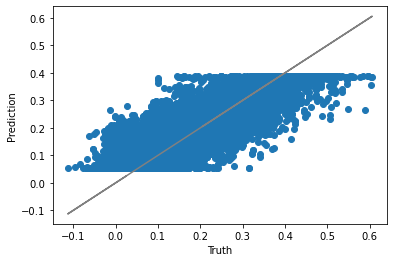

In [19]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'],
           pred,
          )
ax.plot(kf.labels['testing'],
        kf.labels['testing'],
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

In [21]:
model.r_squared(kf.labels['testing'].values[...,None], pred[...,None])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6416687>